# 分析国内股票型基金的盈亏比

导入相关包。

In [1]:
import datetime

import pandas as pd
from jqdatasdk import *

auth('your account', 'your password')
%matplotlib inline

Exception: 认证失败;
您的账号或密码有误，请仔细核对您的账号及密码后重新登录；如您忘记密码可在聚宽官网登录页面修改：https://www.joinquant.com/user/login/index?type=login；其他问题请咨询JQData管理员，微信号：JQData02

获取所有股票型基金数据。

In [69]:
# 获取所有成立超过 3 年的股票型基金数据
year_range = 3
now = datetime.date.today()

start_year = now.year - year_range
fund_end_date = datetime.datetime(start_year, 1, 1).strftime('%Y-%m-%d')

# 结果集
result = None

page = 0
page_size = 3000
while 1:
    df = finance.run_query(
        query(finance.FUND_MAIN_INFO).filter(
            finance.FUND_MAIN_INFO.underlying_asset_type_id=='402001',
            finance.FUND_MAIN_INFO.start_date<fund_end_date,
        ).offset(page * page_size).limit(3000)
    )
    if df.empty:
        break
    if result is None:
        result = df
    else:
        result = pd.concat([result, df], ignore_index=True)
    page += 1

print(result.shape)

(1020, 11)


抽样，打乱结果集顺序，抽取前 30% 的数据来分析

In [70]:
if year_range == 5:
    random_result = result

if year_range == 3:
    random_count = round(result.shape[0] * 0.3)
    random_result = result.sample(frac=1).iloc[:random_count]

In [71]:
random_result.head()

,id,main_code,name,advisor,trustee,operate_mode_id,operate_mode,underlying_asset_type_id,underlying_asset_type,start_date,end_date
168,1077,001663,中银互联网+股票,中银基金管理有限公司,招商银行股份有限公司,401001,开放式基金,402001,股票型,2015-08-06,None
430,4382,510650,金融行业,华夏基金管理有限公司,中国建设银行股份有限公司,401005,ETF,402001,股票型,2013-03-28,None
2,25,000043,嘉实美国成长股票,嘉实基金管理有限公司,中国银行股份有限公司,401003,QDII,402001,股票型,2013-06-14,None
664,7577,001149,汇丰恒生C,汇丰晋信基金管理有限公司,中国邮政储蓄银行股份有限公司,401001,开放式基金,402001,股票型,2015-04-01,None
716,8401,003721,易标普信息科技美元汇,易方达基金管理有限公司,中国建设银行股份有限公司,401003,QDII,402001,股票型,2016-12-13,None


获取样本中 3 年时间段初始累积净值和结束累积净值

In [72]:
start_values = []
end_values = []

for _, row in random_result.iterrows():
    code = row['main_code']
    start_date = row['start_date']

    perf_start_date = start_date.strftime('%Y-%m-%d')
    perf_end_date = datetime.datetime(start_date.year+year_range, start_date.month, start_date.day).strftime('%Y-%m-%d')

    q = query(finance.FUND_NET_VALUE).filter(
        finance.FUND_NET_VALUE.code==code,
        finance.FUND_NET_VALUE.day>=perf_start_date
        ).order_by(finance.FUND_NET_VALUE.day.asc()).limit(1)
    df = finance.run_query(q)
    start_values.append(df.sum_value.values[0] or df.net_value.values[0])

    q = query(finance.FUND_NET_VALUE).filter(
        finance.FUND_NET_VALUE.code==code,
        finance.FUND_NET_VALUE.day<=perf_end_date
        ).order_by(finance.FUND_NET_VALUE.day.desc()).limit(1)
    df = finance.run_query(q)
    if df.empty:
        end_values.append(start_values[-1])
    else:
        end_values.append(df.sum_value.values[0] or df.net_value.values[0])

计算样本收益

In [73]:
random_result['start_value'] = start_values
random_result['end_value'] = end_values
random_result['profit'] = (random_result['end_value'] - random_result['start_value'])/random_result['start_value']

In [74]:
random_result.head()

,id,main_code,name,advisor,trustee,operate_mode_id,operate_mode,underlying_asset_type_id,underlying_asset_type,start_date,end_date,start_value,end_value,profit
168,1077,001663,中银互联网+股票,中银基金管理有限公司,招商银行股份有限公司,401001,开放式基金,402001,股票型,2015-08-06,None,1.0000,0.8210,-0.179000
430,4382,510650,金融行业,华夏基金管理有限公司,中国建设银行股份有限公司,401005,ETF,402001,股票型,2013-03-28,None,1.0000,1.3685,0.368500
2,25,000043,嘉实美国成长股票,嘉实基金管理有限公司,中国银行股份有限公司,401003,QDII,402001,股票型,2013-06-14,None,1.0000,1.2820,0.282000
664,7577,001149,汇丰恒生C,汇丰晋信基金管理有限公司,中国邮政储蓄银行股份有限公司,401001,开放式基金,402001,股票型,2015-04-01,None,1.5159,1.9203,0.266772
716,8401,003721,易标普信息科技美元汇,易方达基金管理有限公司,中国建设银行股份有限公司,401003,QDII,402001,股票型,2016-12-13,None,0.1449,0.2568,0.772257


获取收益的均值、标准差等统计信息

In [75]:
random_result.profit.describe()

count    306.000000
mean       0.082556
std        0.477168
min       -0.986800
25%       -0.196875
50%        0.067647
75%        0.325325
max        3.993000
Name: profit, dtype: float64

计算样本的盈亏比例

In [76]:
profits = random_result.profit.values
total = len(profits)
loss = sum(1 for i in profits if i <= 0)
win = sum(1 for j in profits if j > 0)
print('样本总数: %s, 亏损数: %s, 盈利数: %s, 亏损比例: %s, 盈利比例: %s' % (total, loss, win, round(loss/float(total), 2), round(win/float(total), 2)))

样本总数: 306, 亏损数: 130, 盈利数: 176, 亏损比例: 0.42, 盈利比例: 0.58


查看样本盈亏直方图

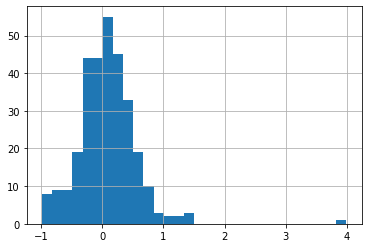

In [77]:
random_result.profit.hist(bins=30)

盈利基金中平均每年收益

In [95]:
avg_profit = sum(j for j in profits if j) / win
i = (1 + avg_profit) ** (1/3) - 1
print(i)


0.04572262830647933
